<a href="https://colab.research.google.com/github/NadezhdaMalysheva/projects/blob/main/TabNet_SDSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Подгружаем необходимые библиотеки 

In [2]:
pip install pytorch-tabnet

In [3]:
import numpy as np
import pandas as pd

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls

%matplotlib inline

In [5]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import joblib
from tqdm.notebook import tqdm

from pytorch_tabnet.tab_model import TabNetClassifier

Подгружаем данные из SDSS обзора, которые были получены: http://skyserver.sdss.org/CasJobs/mydbcontent.aspx?ObjName=SpecPhotoAll&ObjType=TABLE&context=DR16&type=normal 

Здесь уже выполнены следующие преобразования:

1) Удалены строчки с разряженными данными (где отсутствуют интересующие нас фотометрические признаки), выбросы, удалены не интересующие нас признаки

2) Удалены дубрирующиеся данные

3) Объединены основные спектральные классы звезд 

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Научная работа/Nauch/Результат/data/df_done_sub.csv') #выборка с уже объединеными подклассами звезд 
df.head()

,objID,ra,dec,z,zErr,class,subClass,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
0,1237679341106758387,37.470142,-5.554778,0.785255,0.000138,GALAXY,NaN,23.38412,23.00183,22.67571,21.95927,21.39581,20.01718,21.90474,21.99600,21.05722,20.29795
1,1237679341106757929,37.431501,-5.600435,1.285837,3.473993,QSO,NaN,22.52914,23.78679,23.21358,22.17294,21.80350,21.23949,20.26025,22.12909,21.14929,20.66354
2,1237679341106758149,37.388988,-5.556329,0.779955,0.000054,GALAXY,NaN,25.44541,23.13342,23.57675,24.34838,22.31492,20.38550,22.09762,23.74675,24.19759,20.62257
3,1237679440426172681,37.327114,-5.485252,0.714883,0.000028,GALAXY,NaN,25.43466,23.13782,23.31316,22.53812,22.60905,25.45580,22.96513,23.37321,22.59266,22.64923
4,1237679341106692861,37.315868,-5.519308,0.316563,0.000031,GALAXY,NaN,23.17536,21.34756,20.35171,20.05924,19.64511,21.14052,20.62957,19.60872,19.07587,18.90757


In [7]:
df.shape

(4614588, 17)

In [8]:
df.describe()

,objID,ra,dec,z,zErr,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
count,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06
mean,1.237665e+18,1.728012e+02,2.406577e+01,5.773699e-01,5.854844e-02,2.240051e+01,2.122111e+01,2.029666e+01,1.974275e+01,1.938488e+01,2.136179e+01,2.051423e+01,1.961589e+01,1.905677e+01,1.868825e+01
std,8.417649e+12,9.444408e+01,1.910161e+01,7.297733e-01,1.930832e+01,1.954846e+00,1.940199e+00,1.713228e+00,1.552831e+00,1.512268e+00,2.117606e+00,1.993697e+00,1.852755e+00,1.742048e+00,1.677772e+00
min,1.237646e+18,9.090791e-05,-1.970271e+01,-1.144691e-02,-6.000000e+00,6.752299e+00,7.464891e+00,8.449972e+00,7.611034e+00,6.444011e+00,1.020505e+01,1.043573e+01,1.033073e+01,1.027642e+01,8.829096e+00
25%,1.237659e+18,1.271012e+02,6.893257e+00,6.228666e-02,2.494150e-05,2.105644e+01,1.980771e+01,1.908989e+01,1.871800e+01,1.840915e+01,1.987525e+01,1.888042e+01,1.805814e+01,1.767278e+01,1.742591e+01
50%,1.237664e+18,1.741648e+02,2.352539e+01,4.268281e-01,9.249016e-05,2.259238e+01,2.147956e+01,2.063976e+01,2.007801e+01,1.967025e+01,2.116473e+01,2.097991e+01,2.011406e+01,1.942030e+01,1.898551e+01
75%,1.237668e+18,2.271129e+02,3.864779e+01,7.037950e-01,1.989703e-04,2.390630e+01,2.277750e+01,2.155568e+01,2.080758e+01,2.034762e+01,2.250614e+01,2.198993e+01,2.102539e+01,2.035791e+01,1.984414e+01
max,1.237681e+18,3.599999e+02,8.485214e+01,7.051930e+00,3.068822e+04,3.192045e+01,3.032868e+01,2.971638e+01,2.995165e+01,2.748061e+01,3.428534e+01,3.330923e+01,3.088891e+01,3.268382e+01,3.119199e+01


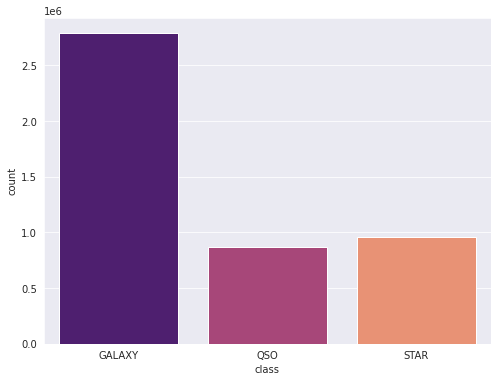

In [9]:
sns.set_style('darkgrid')
plt.figure(figsize = (8, 6))
sns.countplot(x=df['class'], palette = 'magma')

# Подготовка данных для классификатора

In [10]:
target = 'class'

add_columns = ['subClass', 'objID', 'z', 'zErr', 'ra', 'dec']

photo_columns = ['psfMag_u',	'psfMag_g',	'psfMag_r',	'psfMag_i',	'psfMag_z',
                 'cModelMag_u',	'cModelMag_g',	'cModelMag_r',	'cModelMag_i',	'cModelMag_z']

feature_columns = (
    photo_columns + add_columns + [target])

In [11]:
labels = {'STAR':1, 'GALAXY':2, 'QSO':3}
df.replace({target:labels}, inplace = True)

In [93]:
X =  df.drop(add_columns + [target], axis = 1).values
y = df[target].values
X.shape

(4614588, 10)

In [94]:
def data_preparation(X, y, test_size = 0.8):

    X1_train, X1_test, y1_train, y1_test = train_test_split(X[y==1], y[y==1], test_size=test_size, random_state = 43)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X[y==2], y[y==2], test_size=test_size, random_state = 43)
    X3_train, X3_test, y3_train, y3_test = train_test_split(X[y==3], y[y==3], test_size=test_size, random_state = 43)
    
    count = 5000
    count1 = 5000

    X_train, X_test = np.concatenate((X1_train[:count], X2_train[:count], X3_train[:count])), np.concatenate((X1_test[:count1], X2_test[:count1], X3_test[:count1]))
    y_train, y_test = np.concatenate((y1_train[:count], y2_train[:count], y3_train[:count])), np.concatenate((y1_test[:count1], y2_test[:count1], y3_test[:count1]))
    

    return [X_train, X_test, y_train, y_test, X1_train, X1_test, y1_train, y1_test, X2_train, X2_test, y2_train, y2_test, X3_train, X3_test, y3_train, y3_test]

# Аугментация данных 

Полиномиальная 

In [95]:
#from sklearn.preprocessing import PolynomialFeatures
#poly = PolynomialFeatures(2, include_bias=False)
#X = poly.fit_transform(X)

Линейная комбинация

In [96]:
stop = 10 #X.shape[1]
for i in range(stop):
  for j in range(i+1, stop):
    X = np.concatenate((X, np.array([X[:, i] + X[:, j]]).T, np.array([X[:, i] - X[:, j]]).T), axis=1)

In [97]:
X.shape, y

((4614588, 100), array([2, 3, 2, ..., 3, 2, 2]))

# Классификатор Звезд, Галактик и Квазаров

In [98]:
data_split = data_preparation(X, y)

X_train, X_test = data_split[:2]
y_train, y_test = data_split[2:4]

count = 5000

X1_train, X1_test = data_split[4:6]
y1_train, y1_test = data_split[6:8]
X2_train, X2_test = data_split[8:10] 
y2_train, y2_test = data_split[10:12]
X3_train, X3_test = data_split[12:14]
y3_train, y3_test = data_split[14:16]

X_train_pred = np.concatenate((X1_train[count : ], X2_train[count : ], X3_train[count : ])) ###############
X_val_pred   = np.concatenate((X1_test[count : 2*count], X2_test[count : 2*count], X3_test[count : 2*count]))
X_valid      = np.concatenate((X1_test[2*count : 3*count], X2_test[2*count : 3*count], X3_test[2*count : 3*count]))
y_valid      = np.concatenate((y1_test[2*count : 3*count], y2_test[2*count : 3*count], y3_test[2*count : 3*count]))

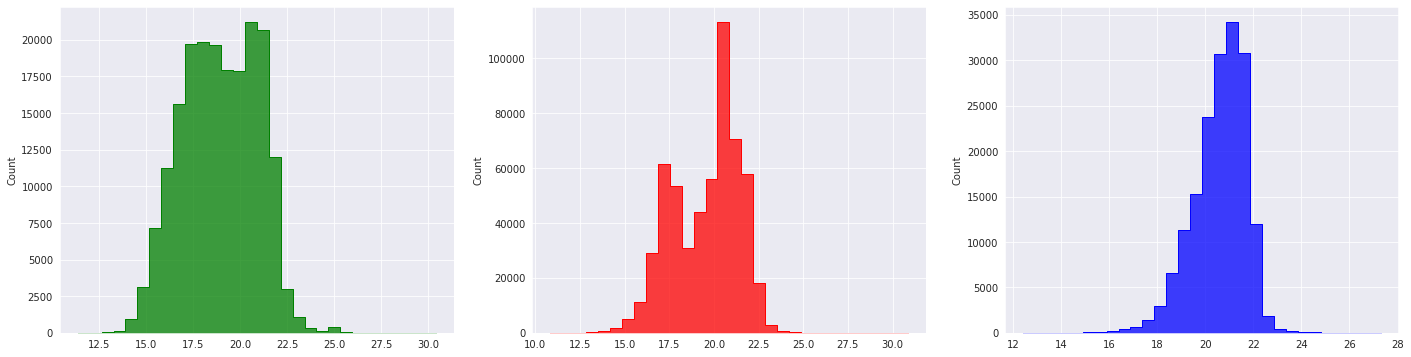

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (24, 6))
sns.histplot(X1_train[:, 7], ax = ax1, bins = 30, color = 'g', element="step")
sns.histplot(X2_train[:, 7], ax = ax2, bins = 30, color = 'r', element="step")
sns.histplot(X3_train[:, 7], ax = ax3, bins = 30, color = 'b', element="step")

Нормализация данных


In [106]:
robust = RobustScaler()

X_train_norm = robust.fit_transform(X_train)
X_test_norm = robust.transform(X_test)
X_valid_norm = robust.transform(X_valid)

# Подбор параметров

# Random Forest and Gradient boosting

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier


lgb_class_params = {
    'learning_rate':    np.uniform(0.001, 0.1),
    'min_child_samples':np.randint(1, 50),
    'colsample_bytree': np.uniform(0.1, 0.9),
    'num_leaves' :      np.randint(10, 100),
    'min_child_weight': np.uniform(0.001, 0.99),
    'n_estimators':     np.randint(100, 1600)
}

kf = KFold(n_splits=5)

LGBM = RandomizedSearchCV(LGBMClassifier(), lgb_class_params, random_state=0, cv=kf)
search = LGBM.fit(X_train_norm, y_train)

In [ ]:
search.best_params_

{'colsample_bytree': 0.7000000000000002,
 'learning_rate': 0.020999999999999998,
 'max_depth': 9,
 'min_child_weight': 5,
 'n_estimators': 900,
 'num_leaves': 100}

In [ ]:
gb = LGBMClassifier(**search.best_params_)
gb.fit(X_train_norm, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.7000000000000002, importance_type='split',
               learning_rate=0.020999999999999998, max_depth=9,
               min_child_samples=20, min_child_weight=5, min_split_gain=0.0,
               n_estimators=900, n_jobs=-1, num_leaves=100, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
pred = search.predict(X_test_norm)#совместно  
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, search.predict(X_train_norm))
print('Training Score: ', gb_train_acc)
gb_test_acc =  accuracy_score(y_test, pred)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.89      0.86      0.88      5000
           2       0.91      0.95      0.93      5000
           3       0.86      0.85      0.85      5000

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000

Confusion Matrix: 
 [[4315  141  544]
 [  78 4766  156]
 [ 429  321 4250]]
Training Score:  1.0
Testing Score:  0.8887333333333334


In [ ]:
pred = search.predict(X_test_norm)#с линейной комбинацией  
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, search.predict(X_train_norm))
print('Training Score: ', gb_train_acc)
gb_test_acc =  accuracy_score(y_test, pred)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.89      0.87      0.88      5000
           2       0.91      0.95      0.93      5000
           3       0.86      0.85      0.86      5000

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000

Confusion Matrix: 
 [[4326  140  534]
 [  83 4765  152]
 [ 435  313 4252]]
Training Score:  0.9986666666666667
Testing Score:  0.8895333333333333


In [ ]:
pred = search.predict(X_test_norm)#с полиномиальной аугментацией  
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, search.predict(X_train_norm))
print('Training Score: ', gb_train_acc)
gb_test_acc =  accuracy_score(y_test, pred)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.88      0.85      0.86      5000
           2       0.91      0.94      0.93      5000
           3       0.84      0.83      0.84      5000

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000

Confusion Matrix: 
 [[4245  154  601]
 [  90 4724  186]
 [ 510  316 4174]]
Training Score:  0.9999333333333333
Testing Score:  0.8762


In [ ]:
pred = search.predict(X_test_norm)#без аугментации 
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, search.predict(X_train_norm))
print('Training Score: ', gb_train_acc)
gb_test_acc =  accuracy_score(y_test, pred)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.88      0.85      0.86      5000
           2       0.91      0.94      0.92      5000
           3       0.84      0.83      0.83      5000

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000

Confusion Matrix: 
 [[4234  151  615]
 [  93 4700  207]
 [ 510  323 4167]]
Training Score:  0.9766
Testing Score:  0.8734


In [ ]:
rf = RandomForestClassifier(n_estimators=300, random_state=42, max_features=5, min_samples_leaf=1) 
rf.fit(X_train_norm, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
pred = rf.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
rf_train_acc = accuracy_score(y_train, rf.predict(X_train_norm))
print('Training Score: ', rf_train_acc)
rf_test_acc =  accuracy_score(y_test, pred)
print('Testing Score: ', rf_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.88      0.85      0.87      5000
           2       0.91      0.94      0.93      5000
           3       0.84      0.84      0.84      5000

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000

Confusion Matrix: 
 [[4265  147  588]
 [  90 4722  188]
 [ 483  325 4192]]
Training Score:  1.0
Testing Score:  0.8786


In [71]:
from hyperopt import hp
import numpy as np
from sklearn.metrics import mean_squared_error, f1_score

def scor(y_test, y_pred):
  return accuracy_score(y_test, y_pred)

lgb_reg_params = {
    'learning_rate':    hp.uniform('learning_rate', 0.001, 0.1),
    'min_child_samples':hp.randint('min_child_samples', 50)+1,
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.9),
    'num_leaves' :      hp.randint('num_leaves', 100)+10,
    'min_child_weight': hp.uniform('min_child_weight', 0.001, 0.99),
    'n_estimators':     hp.randint('n_estimators', 1500)+100
}
lgb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['score'] = lambda y, pred: -accuracy_score(y, pred)


rf_reg_params = {
    'min_samples_leaf': hp.randint('min_samples_leaf', 20)+1,
    'min_samples_split':hp.uniform('min_samples_split', 0.001, 0.1),
    #'max_features':     hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
    #'learning_rate':    hp.uniform('learning_rate', 0.001, 0.1),
    'n_estimators':     hp.randint('n_estimators', 800)+100
}
rf_fit_params = {
}
rf_para = dict()
rf_para['reg_params'] = rf_reg_params
rf_para['fit_params'] = rf_fit_params
rf_para['score'] = lambda y, pred: -accuracy_score(y, pred)

tabnet_reg_params = {
    'n_d' :              64,
    'n_a' :              64,
    'n_steps' :          hp.randint('n_steps', 10-3)+3,
    'gamma' :            hp.uniform('gamma', 1.0, 3.0),
    'lambda_sparse' :    hp.uniform('lambda_sparse', 0.0, 0.01),
    'momentum' :         0.3, 
    'clip_value' :       2.,
    'optimizer_params' : dict(lr=2e-2),
    'scheduler_params' : {"step_size":50, "gamma":0.9},
    'scheduler_fn' :     torch.optim.lr_scheduler.StepLR,
    'mask_type' :       'entmax'
}

tabnet_fit_params = {
    'max_epochs' : 100, 
    'patience' : 15,
    'batch_size' : 512,
    'virtual_batch_size' : 128,
    'num_workers' : 0,
    'weights' : 1,
    'drop_last' : False,
    #'from_unsupervised' : unsupervised_model
}
tabnet_para = dict()
tabnet_para['reg_params'] = tabnet_reg_params
tabnet_para['fit_params'] = tabnet_fit_params
tabnet_para['score'] = lambda y, pred: -accuracy_score(y, pred)

In [72]:
import lightgbm as lgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials


class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test
        self.X = np.concatenate((x_traun, x_test))
        self.y = np.concatenate((y_traun, y_test))

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def rf_reg(self, para):
        reg = RandomForestClassifier(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMClassifier(**para['reg_params'])
        return self.train_reg(reg, para)

    def tabnet_reg(self, para):
        #print(6)
        reg = TabNetClassifier(**para['reg_params'])
        return self.train_reg(reg, para)


    def train_reg(self, reg, para):
        if len(para['fit_params'])>0:
            reg.fit(self.x_train, self.y_train,
                  eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                  **para['fit_params'])
        else:
            reg.fit(self.x_train, self.y_train)
        pred = reg.predict(self.x_test)
        loss = para['score'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

def train_cv(self, reg, para):
        kf = KFold(n_splits=3)
        loss = 0 
        for train, test in kf.split(X):
            if len(para['fit_params'])>0:
                reg.fit(X[train], y[train],
                      eval_set=[(X[train], y[train]), (X[test], y[test])],
                      **para['fit_params'])
            else:
                reg.fit(X[train], y[train])
            pred = reg.predict(X[test])
            loss += para['score'](y[test], pred)
        loss=loss/3
        return {'loss': loss, 'status': STATUS_OK}


In [ ]:
obj = HPOpt(X_train_norm, X_test_norm, y_train, y_test)

In [ ]:
lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=1000)

100%|██████████| 1000/1000 [2:44:53<00:00,  9.89s/it, best loss: -0.8928]


In [ ]:
lgb_opt

({'colsample_bytree': 0.6437405148446416,
  'learning_rate': 0.0741521019613115,
  'min_child_samples': 9,
  'min_child_weight': 0.43858057836890685,
  'n_estimators': 77,
  'num_leaves': 59},
 <hyperopt.base.Trials at 0x7f7912522c10>)

In [107]:
gb = lgb.LGBMClassifier(  #ЛУЧШАЯ МОДЕЛЬ
  **{'colsample_bytree': 0.6437405148446416,
  'learning_rate': 0.0741521019613115,
  'min_child_samples': 9+1,
  'min_child_weight': 0.43858057836890685,
  'n_estimators': 77+100,
  'num_leaves': 59+10}
  )
gb.fit(X_train_norm, y_train, eval_set=[(X_train_norm, y_train), (X_valid_norm, y_valid)],  **lgb_fit_params)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.6437405148446416, importance_type='split',
               learning_rate=0.0741521019613115, max_depth=-1,
               min_child_samples=10, min_child_weight=0.43858057836890685,
               min_split_gain=0.0, n_estimators=177, n_jobs=-1, num_leaves=69,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [109]:
pred = gb.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb.predict(X_train_norm))
print('Training Score: ', gb_train_acc)
gb_test_acc =  accuracy_score(y_test, pred)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.90      0.87      0.88      5000
           2       0.91      0.95      0.93      5000
           3       0.87      0.85      0.86      5000

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000

Confusion Matrix: 
 [[4353  139  508]
 [  82 4766  152]
 [ 408  319 4273]]
Training Score:  0.9833333333333333
Testing Score:  0.8928


In [ ]:
rf_opt = obj.process(fn_name='rf_reg', space=rf_para, trials=Trials(), algo=tpe.suggest, max_evals=10)

100%|██████████| 10/10 [13:03<00:00, 78.33s/it, best loss: -0.8726]


In [ ]:
rf_opt

({'min_samples_leaf': 18,
  'min_samples_split': 0.020512200509857588,
  'n_estimators': 3},
 <hyperopt.base.Trials at 0x7f7911548d10>)

In [ ]:
rf = RandomForestClassifier(
    **{'min_samples_leaf': 14+1,
    'min_samples_split': 0.004808678129900561,
    'n_estimators': 623+100}
) 
rf.fit(X_train_norm, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15,
                       min_samples_split=0.004808678129900561,
                       min_weight_fraction_leaf=0.0, n_estimators=723,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
pred = rf.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
rf_train_acc = accuracy_score(y_train, rf.predict(X_train_norm))
print('Training Score: ', rf_train_acc)
rf_test_acc =  accuracy_score(y_test, pred)
print('Testing Score: ', rf_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.89      0.85      0.87      5000
           2       0.90      0.95      0.92      5000
           3       0.85      0.84      0.85      5000

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000

Confusion Matrix: 
 [[4245  187  568]
 [  79 4761  160]
 [ 452  352 4196]]
Training Score:  0.9008666666666667
Testing Score:  0.8801333333333333


# TabNet


In [15]:
import torch

In [ ]:
from pytorch_tabnet.pretraining import TabNetPretrainer

unsupervised_model = TabNetPretrainer(
    n_d=64, n_a=64, n_steps=8,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax' # "sparsemax"
)

unsupervised_model.fit(
    X_train=X_train_pred,
    eval_set=[X_val_pred],
    max_epochs=10 , patience=5,
    batch_size=512, virtual_batch_size=128,
    pretraining_ratio=0.8,
)

Подбор параметров 

In [ ]:
obj = HPOpt(X_train, X_valid, y_train, y_valid)

In [ ]:
tabnet_opt = obj.process(fn_name='tabnet_reg', space=tabnet_para, trials=Trials(), algo=tpe.suggest, max_evals=10)

In [ ]:
tabnet_opt

({'gamma': 2.7783389741405147,
  'lambda_sparse': 0.02378813297614627,
  'n_steps': 3},
 <hyperopt.base.Trials at 0x7f88e2a7d090>)

In [56]:
clf = TabNetClassifier(n_d=64, n_a=64,
                       momentum=0.3, clip_value=2.,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":50, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,

                       mask_type='entmax',
                       **{'gamma': 2.7783389741405147,
                          'lambda_sparse': 0.02378813297614627,
                          'n_steps': 8}

)

Device used : cuda


In [57]:
max_epochs = 200

In [ ]:
clf.fit(
    X_train=X_train, y_train=y_train,
    #X_valid=X_valid, y_valid=y_valid,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['logloss','accuracy'],
    max_epochs=max_epochs , patience=20,
    batch_size=256, virtual_batch_size=128,
    #from_unsupervised=unsupervised_model
) 

In [ ]:
clf.fit(
    X_train=X_train, y_train=y_train,
    #X_valid=X_valid, y_valid=y_valid,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['logloss','accuracy'],
    max_epochs=max_epochs , patience=20,
    batch_size=256, virtual_batch_size=128,
    #from_unsupervised=unsupervised_model
) 

In [59]:
pred = clf.predict(X_test)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
clf_train_acc = accuracy_score(y_train, clf.predict(X_train))
print('Training Score: ', clf_train_acc)
clf_test_acc = accuracy_score(y_test, pred)
print('Training Score: ', clf_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.90      0.86      0.88      5000
           2       0.92      0.95      0.93      5000
           3       0.85      0.87      0.86      5000

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000

Confusion Matrix: 
 [[4298  137  565]
 [  90 4733  177]
 [ 373  289 4338]]
Training Score:  0.9059333333333334
Training Score:  0.8912666666666667


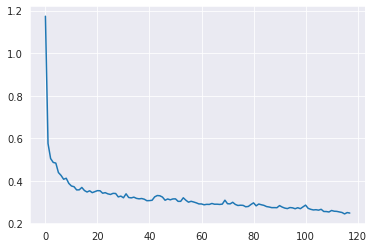

In [60]:
# plot losses
plt.plot(clf.history['loss'])

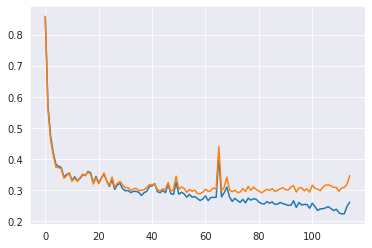

In [62]:
# plot accuracy
plt.plot(clf.history['train_logloss'][3:])
plt.plot(clf.history['valid_logloss'][3:])

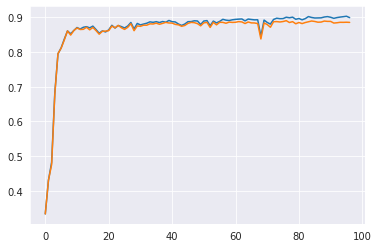

In [ ]:
# plot accuracy
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

In [80]:
photo_columns

['psfMag_u',
 'psfMag_g',
 'psfMag_r',
 'psfMag_i',
 'psfMag_z',
 'cModelMag_u',
 'cModelMag_g',
 'cModelMag_r',
 'cModelMag_i',
 'cModelMag_z']

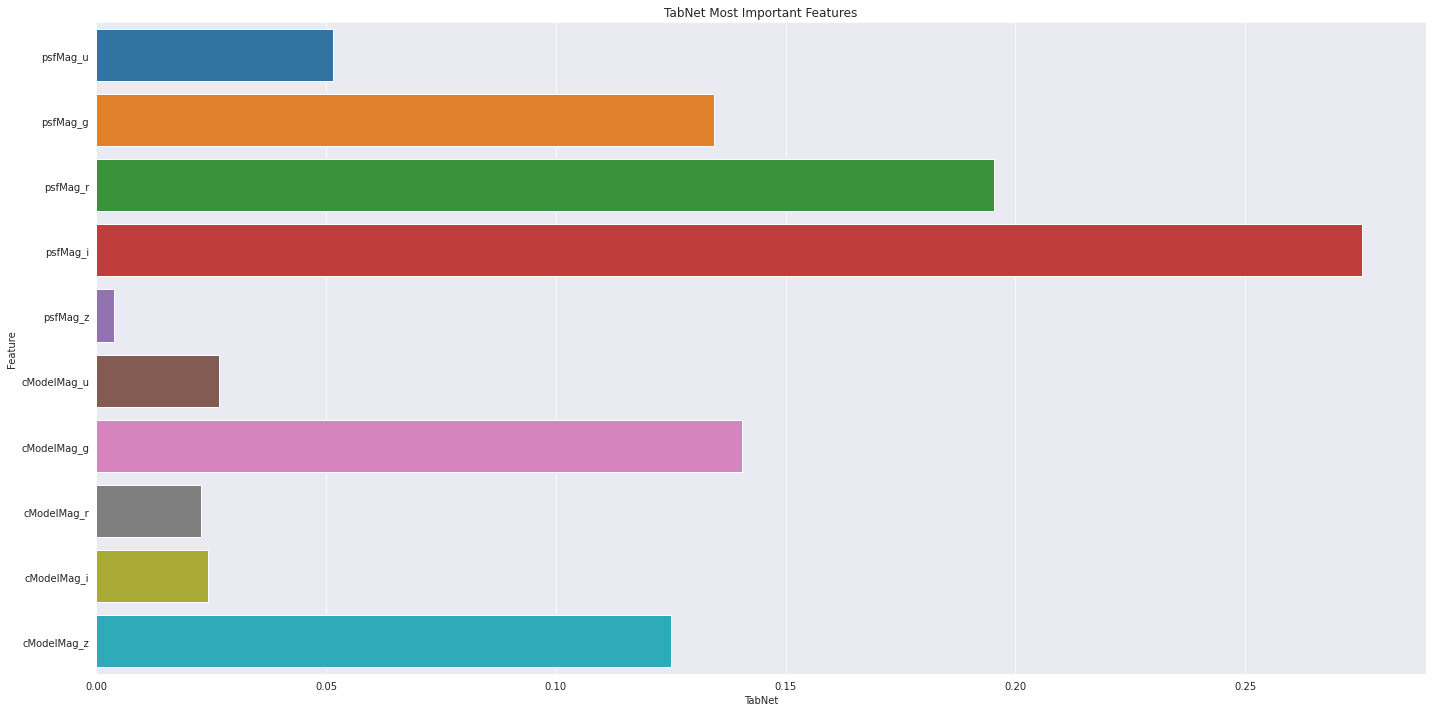

In [126]:
feature_imp=pd.DataFrame((zip(clf.feature_importances_,photo_columns)), columns=['TabNet','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="TabNet", y="Feature", data=feature_imp)
plt.title('TabNet Most Important Features')
plt.tight_layout()
plt.show()

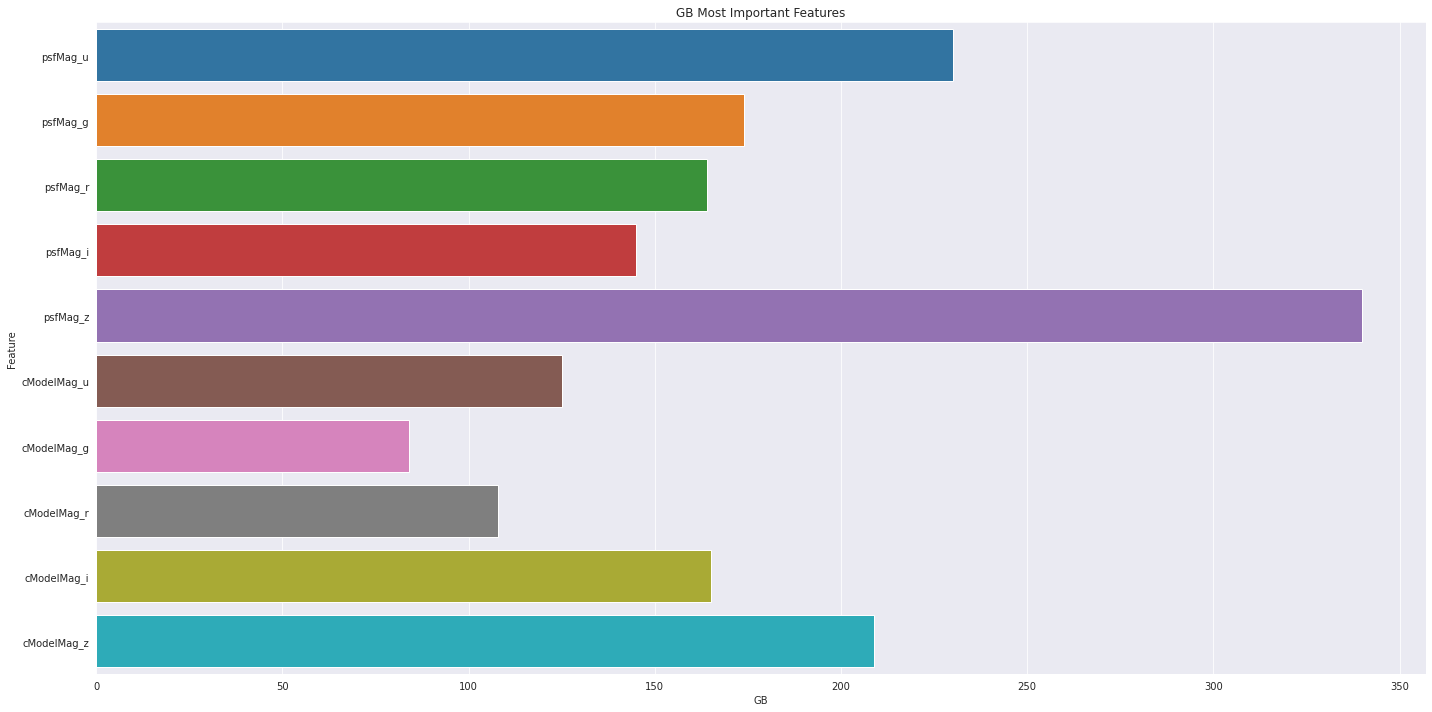

In [127]:
feature_impgb=pd.DataFrame((zip(gb.feature_importances_[:10],photo_columns)), columns=['GB','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="GB", y="Feature", data=feature_impgb)
plt.title('GB Most Important Features')
plt.tight_layout()
plt.show()

In [132]:
dff = feature_impgb.merge(feature_imp, how='outer')
cols = dff.columns.tolist()
cols = cols[1:] + cols[:1]
dff = dff[cols]
dff

,Feature,TabNet,GB
0,psfMag_u,0.051430,230
1,psfMag_g,0.134346,174
2,psfMag_r,0.195410,164
3,psfMag_i,0.275490,145
4,psfMag_z,0.003827,340
5,cModelMag_u,0.026733,125
6,cModelMag_g,0.140519,84
7,cModelMag_r,0.022828,108
8,cModelMag_i,0.024334,165
9,cModelMag_z,0.125083,209


In [111]:
explain_matrix, masks = clf.explain(X_test)

Text(0.5, 1.0, 'explain mask')

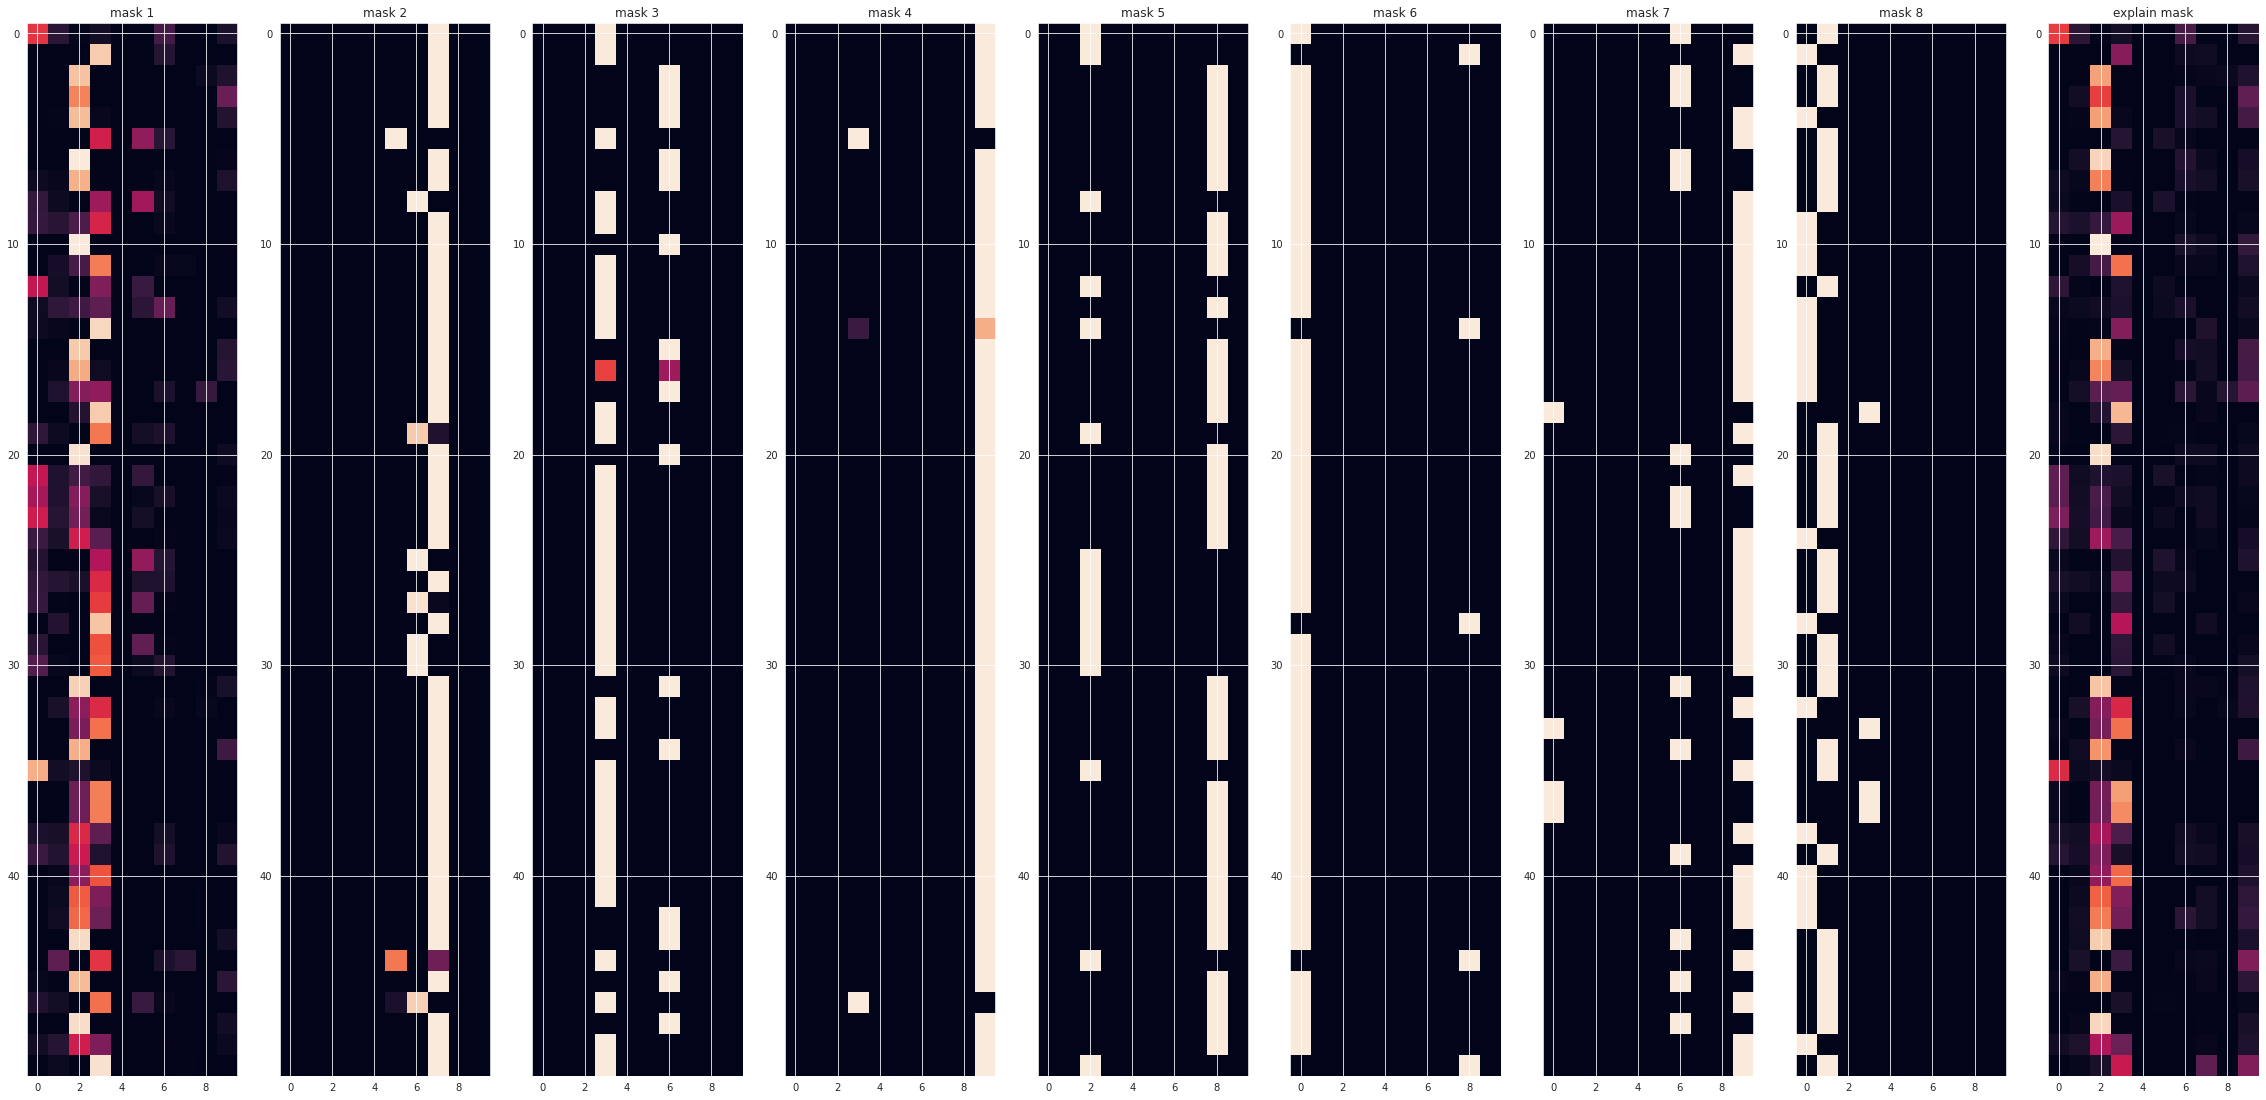

In [114]:
fig, axs = plt.subplots(1, 9, figsize=(40,40))

for i in range(8):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i+1}")

axs[i+1].imshow(explain_matrix[:50])
axs[i+1].set_title("explain mask")